# SHAP Demo

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
from sklearn.datasets import make_classification

mpl.rcParams["figure.dpi"] = 400
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Generate Synthetic Data

In [3]:
X, y = make_classification(
    n_samples=5000,
    n_features=40,
    n_informative=3,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=3,
    weights=None,
    flip_y=0.05,
    class_sep=0.1,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=2,
)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)

In [5]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [6]:
y.mean()

0.4986

## `lossguide` tree growing

Creating a tree to explain later

In [7]:
xgb_model_3 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective="binary:logistic",
    use_label_encoder=False,
    n_jobs=-1,
    tree_method="hist",
    grow_policy="lossguide",
)

In [8]:
max_leaves_values = list(range(5, 105, 5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [9]:
val_aucs = []
for max_leaves in max_leaves_values:
    # Set parameter and fit model
    xgb_model_3.set_params(**{"max_leaves": max_leaves})
    xgb_model_3.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric="auc",
        verbose=False,
        early_stopping_rounds=30,
    )

    # Get validation score
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:, 1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

In [10]:
max_leaves_df = pd.DataFrame(
    {"Max leaves": max_leaves_values, "Validation AUC": val_aucs}
)

<Axes: xlabel='Max leaves'>

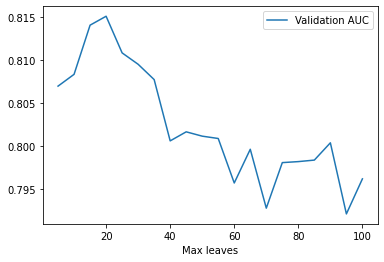

In [11]:
mpl.rcParams["figure.dpi"] = 400
max_leaves_df.set_index("Max leaves").plot()

In [12]:
max_auc = max_leaves_df["Validation AUC"].max()
max_auc

0.8151281015048877

In [13]:
max_ix = max_leaves_df["Validation AUC"] == max_auc
max_leaves_df[max_ix]

,Max leaves,Validation AUC
3,20,0.815128


## SHAP values

Train model with optimal max leaves first:

In [14]:
xgb_model_3.set_params(**{"max_leaves": 20})
xgb_model_3.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric="auc",
    verbose=False,
    early_stopping_rounds=30,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=20,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
X_val.shape

(1000, 40)

In [16]:
feature_names = [
    "Feature {number}".format(number=number) for number in range(X_val.shape[1])
]
X_val_df = pd.DataFrame(data=X_val, columns=feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [17]:
explainer = shap.explainers.Tree(xgb_model_3, data=X_val_df)

In [18]:
shap_values = explainer(X_val_df)

In [19]:
print(shap_values.values.shape)
shap_values[0,:]

(1000, 40)


.values =
array([-0.00794692,  0.12648143, -0.0310879 ,  0.17802333, -0.00118312,
       -0.41991899,  0.00517463, -0.00215094,  0.00857748, -0.0536672 ,
       -0.05562352, -0.11352685, -0.04370205,  0.01856001,  0.00115922,
       -0.05572917,  0.01439217, -0.05683122, -0.00161014, -0.00759129,
       -0.03215507, -0.00637211, -0.02461622,  0.01400656, -0.08915649,
        0.00999061,  0.00447506,  0.00196164, -0.02872493,  0.01242667,
       -0.01190503, -0.01213292,  0.00343266,  0.01789875, -0.0154327 ,
        0.01144121, -0.00999723, -0.00331191, -0.01799517, -0.30525244])

.base_values =
-0.05156415286367643

.data =
array([ 1.85288474, -2.17029295,  1.05728846,  0.44187268, -0.80313088,
       -0.02513907, -0.03714259,  0.03756456,  1.16399524,  0.6784101 ,
       -1.32961626, -1.2069031 , -0.01123982, -0.71176266,  0.98224798,
       -0.15329425,  0.39736143,  0.4521837 , -0.32664987, -1.35972895,
       -0.33510936, -0.17296188,  1.75100806, -0.97147251, -2.26581524,
       

### SHAP represented as a graph

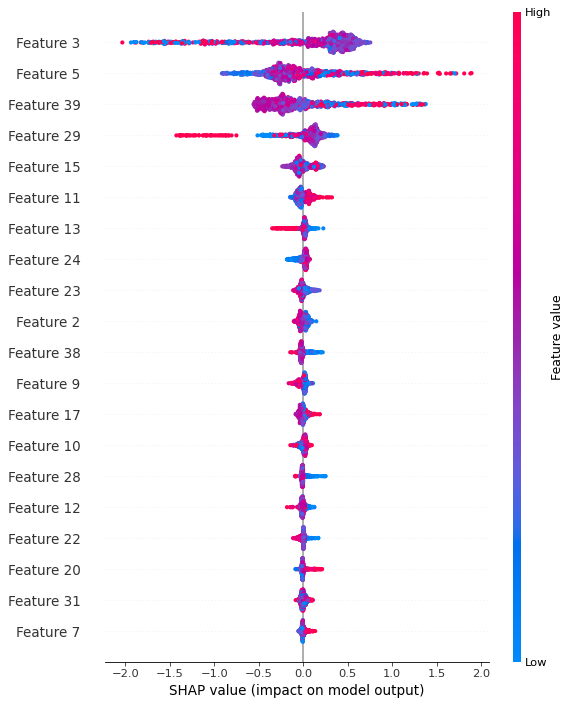

In [20]:
mpl.rcParams["figure.dpi"] = 75
shap.summary_plot(shap_values.values, X_val_df)

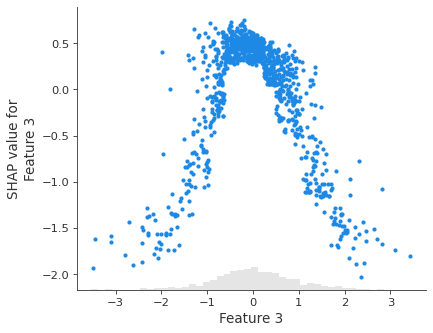

In [21]:
shap.plots.scatter(shap_values[:, "Feature 3"])

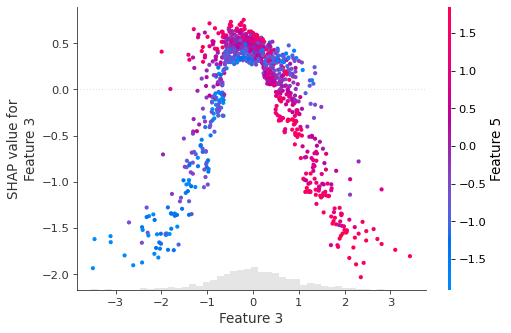

In [22]:
shap.plots.scatter(shap_values[:, "Feature 3"], color=shap_values[:, "Feature 5"])

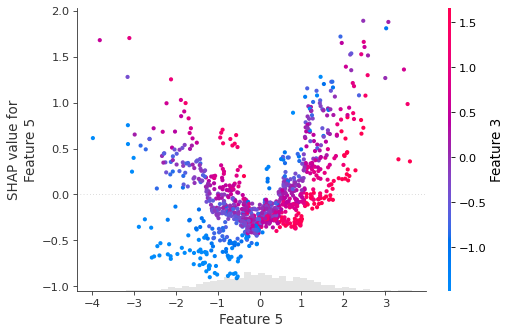

In [23]:
shap.plots.scatter(shap_values[:, "Feature 5"], color=shap_values[:, "Feature 3"])

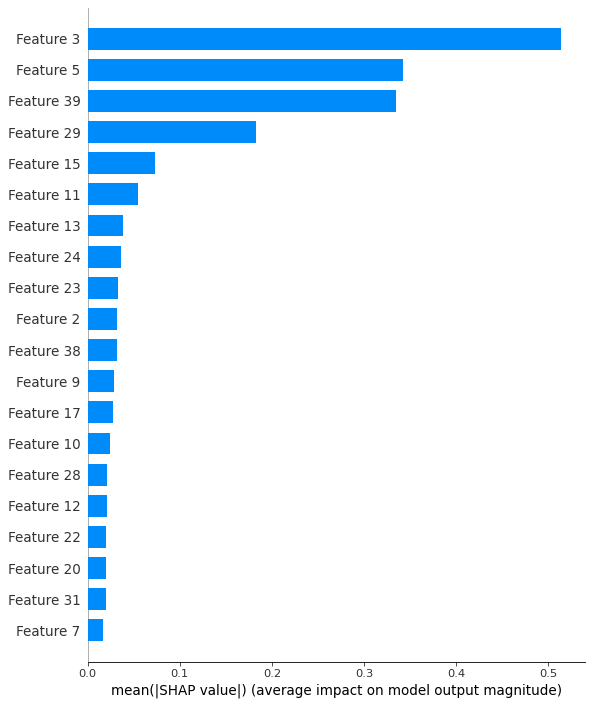

In [24]:
mpl.rcParams["figure.dpi"] = 75
shap.summary_plot(shap_values.values, X_val, plot_type="bar")

### Reconstruct predict probabilities from SHAP values:

In [25]:
shap_values.values.shape

(1000, 40)

In [26]:
explainer.expected_value

-0.05156415286367643

In [27]:
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value
shap_sum.shape

(1000,)

In [28]:
shap_sum_prob = 1 / (1 + np.exp(-1 * shap_sum))

In [29]:
y_pred_proba = xgb_model_3.predict_proba(X_val)[:, 1]
y_pred_proba.shape

(1000,)

In [30]:
df_check = pd.DataFrame(
    {"SHAP sum": shap_sum_prob, "Predicted probability": y_pred_proba}
)
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
507,0.497253,0.497253
818,0.466154,0.466154
452,0.881365,0.881365
368,0.145359,0.145359
242,0.481085,0.481085


In [31]:
np.allclose(df_check["SHAP sum"], df_check["Predicted probability"])

True

In [32]:
np.array_equal(df_check["SHAP sum"], df_check["Predicted probability"])

False

<Axes: xlabel='Predicted probability', ylabel='SHAP sum'>

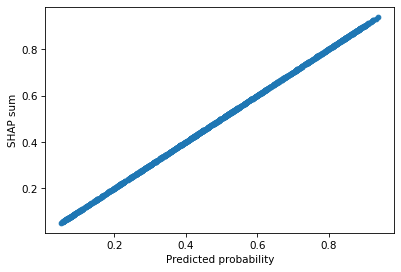

In [33]:
df_check.plot.scatter(x="Predicted probability", y="SHAP sum")